In [873]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

df = pd.read_csv('return_avg.csv')
rank = pd.read_csv('rank.csv')
data = df.values

In [867]:
def strategy_num(number): # taking only action of corresponding number
    env = Stock()
    env.y = 179
    env.counts = 119 # in order to stop after taking 60 action
    while not env.is_terminal():
        action = number
        env.step(action)
    return env.capital

def strategy_random(): # taking random actions
    env = Stock()
    env.y = 179
    env.counts = 119 # in order to stop after taking 60 action
    while not env.is_terminal():
        action = random.randint(1,10)
        env.step(action)
    return env.capital

def last_best(): # taking the same action of last month's best action 
    env = Stock()
    env.y = 179
    env.counts = 119 # in order to stop after taking 60 action
    while not env.is_terminal():
        action = np.argmin(rank.iloc[env.y,].tolist()[1:-1])+1
        env.step(action)
    return env.capital

In [937]:
state_list = []
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

for i in range(240):
    a=rank.iloc[i,].tolist()[1:-1]
    b=np.argsort(a)[:1]
    b+=1
    b=totuple(b)
    state_list.append(b)

#print(state_list[:30])
#raise ValueError

class Stock():

    def __init__(self):
        self.capital = 1
        self.x = 1
        self.y = 0
        self.last_action = self.x
        self.last_rank=1
        self.last_best=1
        self.counts = 0 # we count to 180 months, 15 years.
        self.state = (self.last_action, self.last_rank, state_list[self.counts][0])
        self.iter_num = 0 
        self.discount = 1/1.03
        # Initialize self.q_values to all 0
        self.q_values = {}
        for last_action in range(1,11): 
            for last_rank in range(1,11):
                for last_best in range(1,11):
                    for action in range(1,11):
                        self.q_values[((last_action, last_rank, last_best), action)] = 0.0
    
    def step(self, action):
        self.x = action
        self.y += 1
        self.counts += 1
        self.state = (self.last_action, self.last_rank, self.last_best)
        if not self.is_terminal():
            self.capital += data[self.y, self.x] * self.capital 
          
    def reset(self):
        self.x = 1
        self.y = 0
        self.last_action = self.x
        self.last_rank=1
        self.capital=1 # original capital hold
        self.counts = 0 # indicate which month
        self.state = (self.last_action, self.last_rank, self.last_best)
        self.iter_num += 1 # iteration times of learning
    
    def is_terminal(self):
        return self.counts == 180
    
    def get_reward(self):
        return data[self.y, self.x] 
             
    def getQValue(self, state, action):
        return self.q_values[(state, action)]

    def computeValueFromQValues(self, state):
        if self.is_terminal():
            return  0.0
        else: # extract the largest value within the ten actions under state
            return max([self.q_values[(state, action)] for action in range(1,11)])

    def computeActionFromQValues(self, state):
        values = [self.q_values[(state, action)] for action in range(1,11)]
        if values == [0.0] * 10:
            return random.randint(1,10)
        else:
            return np.argmax([self.q_values[(state, action)] for action in range(1,11)])+1

    def getAction(self, state):
        if not self.is_terminal():
            num = random.randint(0,9)
            if num == 0: # 10% probability of taking random actions
                self.last_action=random.choice([i+1 for i in range(10)])
                self.last_rank=rank.iloc[self.y,self.last_action]
                self.last_best=np.argmin(rank.iloc[self.y,].tolist()[1:-1])+1
                return self.last_action
            else:
                self.last_action=self.getPolicy(state)
                self.last_rank=rank.iloc[self.y,self.last_action]
                self.last_best=np.argmin(rank.iloc[self.y,].tolist()[1:-1])+1
                return self.last_action
        else:
            return None

    def update_q(self, state, action):
        values=[]
        for i in range(1,11):
            nextState = (self.last_action,self.last_rank,i)
            values.append(self.getValue(nextState))
        self.q_values[(state, action)] = self.getQValue(state, action) + \
                                1/(self.iter_num + 1) * \
                                (self.get_reward() + self.discount*max(values))

    def getPolicy(self, state):
        return self.computeActionFromQValues(state)

    def getValue(self, state):
        return self.computeValueFromQValues(state)
     
    
def train(iterations):
    env = Stock()
    env.q_values = {}
    for last_action in range(1,11): 
        for last_rank in range(1,11):
            for last_best in range(1,11):
                for action in range(1,11):
                    env.q_values[((last_action, last_rank, last_best), action)] = 0.0
    for i in range(iterations):
        env.reset()
        while not env.is_terminal():
            action = env.getAction(env.state)
            env.update_q(env.state, action)
            env.step(action)
    return env.q_values, env.capital

            
def test(q_val_dic):
    env = Stock()
    env.y = 179
    env.counts = 119# in order to stop after taking 60 action
    env.q_values = q_val_dic
    while not env.is_terminal():
        action = env.getPolicy(env.state)
        env.step(action)
    return env.capital

def strategy_num(number): # taking only action 1
    env = Stock()
    env.y = 179
    env.counts = 119 # in order to stop after taking 60 action
    while not env.is_terminal():
        action = number
        env.step(action)
    return env.capital

# In this project, we use the monthly data between Jan 1999 and Dec 2013 for training, and data between Jan 2014 and Dec 2018 for testing. We compare the final capital given the initial capital with unit 1.

In [933]:
result=[]
for i in range(100):
    a=test(train(100)[0])
    result.append(a)
print("This is the result of RL startegy portfolio, which is the average of 100 portfolio returns",np.mean(result))

This is the result of RL startegy portfolio, which is the average of 100 portfolio returns 3.5347716883773104


In [932]:
results=[]
for i in range(100):
    a=test(train(10)[0])
    results.append(a)
print("This is the result of RL startegy portfolio, which is the average of 100 portfolio returns",np.mean(results))

This is the result of RL startegy portfolio, which is the average of 100 portfolio returns 3.598778306792883


In [872]:
print('This is the result of strategy 1:', strategy_num(1))
print('This is the result of strategy 2:', strategy_num(2))
print('This is the result of strategy 3:', strategy_num(3))
print('This is the result of strategy 4:', strategy_num(4))
print('This is the result of strategy 5:', strategy_num(5))
print('This is the result of strategy 6:', strategy_num(6))
print('This is the result of strategy 7:', strategy_num(7))
print('This is the result of strategy 8:', strategy_num(8))
print('This is the result of strategy 9:', strategy_num(9))
print('This is the result of strategy 10:', strategy_num(10))

This is the result of strategy 1: 6.298907917656164
This is the result of strategy 2: 2.479864631938624
This is the result of strategy 3: 1.7213618841631522
This is the result of strategy 4: 1.3919845235307966
This is the result of strategy 5: 1.0996862010461648
This is the result of strategy 6: 1.2160133818025693
This is the result of strategy 7: 0.9532259494628706
This is the result of strategy 8: 1.0548113135754105
This is the result of strategy 9: 0.9737379987585048
This is the result of strategy 10: 1.1029772850481367


In [875]:
randoms=[]
for i in range(100):
    a=strategy_random()
    randoms.append(a)
print("This is the result of random startegy, which is the average of 100 portfolio returns",np.mean(randoms))

This is the result of random startegy, which is the average of 100 portfolio returns 1.5378923767256614


In [877]:
print('This is the result of last_best startegy:', last_best())

This is the result of last_best startegy: 6.052762944259469


In [876]:
print("This is the result of investing in Shanghai Composite Index",2493.896/2289.510)
print("This is the result of investing in Shenzhen Composite Index",7239.789/9204.114)

This is the result of investing in Shanghai Composite Index 1.0892706299601225


In [939]:
returns=[np.mean(results),strategy_num(1),strategy_num(2),strategy_num(3),strategy_num(4),strategy_num(5),strategy_num(6),strategy_num(7),strategy_num(8),strategy_num(9),strategy_num(10),np.mean(randoms),last_best(),2493.896/2289.510,7239.789/9204.114]

In [940]:
strategies=["Reinforcement Learning","Portfolio 1","Portfolio 2","Portfolio 3","Portfolio 4","Portfolio 5","Portfolio 6","Portfolio 7","Portfolio 8","Portfolio 9","Portfolio 10","Random","Last_Best","Shanghai Index","Shenzhen Index"]

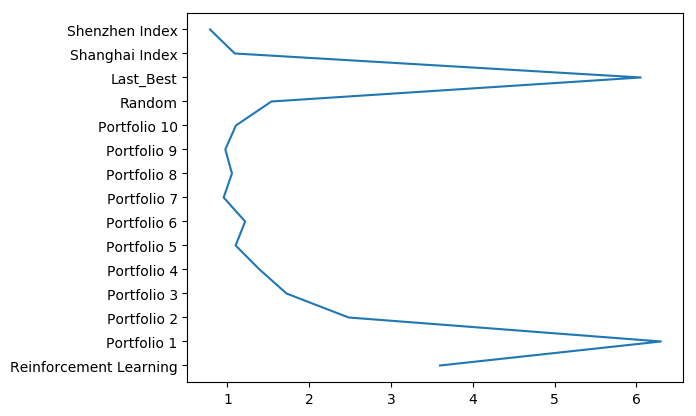

In [941]:
plt.plot(returns,strategies)

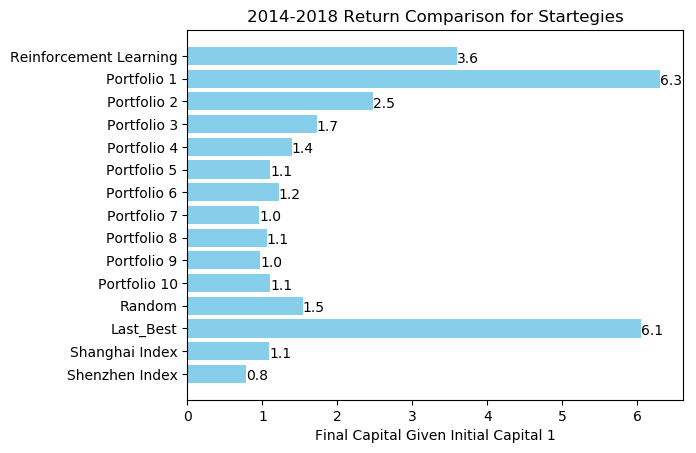

In [942]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
y_pos = np.arange(len(strategies))
ax.barh(y_pos, returns, align='center',
        color='skyblue', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(strategies)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Final Capital Given Initial Capital 1')
ax.set_title('2014-2018 Return Comparison for Startegies')
for i, v in enumerate(returns):
    ax.text(v , i + .28, str(round(v*10)/10), color='black')
plt.show()